# Workshop 1: Finite Elements for Linear Elasticity
In this tutorial you will learn how to implement a Finite Element solver to solve the linear elasticity problem in a 2-dimensional domain.

Before starting, we install some packages that will be required in this notebook. In particular, here we install [**Gmsh**](https://gmsh.info/), a widely used open-source software for mesh generation. Please, follow the [*gmsh documentation*](https://gmsh.info/#Documentation) for a more in-depth description of how to use it.

In [125]:
pip install gmsh

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Let’s first initialize the notebook and define some parameters. In this example we will consider a rectangular domain of sides `d1` and `d2`  with a circular hole of radius `R` at the center.

## Step 1: Discretize the domain

Here we will use the **Gmsh** software to discretize the domain with triangles. The same software can be used to generate quadrilateral meshes or 3D meshes.

Let's first import the required packages and define some domain parameters

In [126]:
import gmsh
import numpy as np

# Domain parameters
d1 = 1.0  # Length of the domain in x-direction
d2 = 1.0  # Length of the domain in y-direction
R = 0.3 # Radius of the circle

In what follows we use the Python API of Gmsh to create the mesh. You will find all the information on how to use this API [here](https://gmsh.info/doc/texinfo/gmsh.html#Gmsh-application-programming-interface). The main steps that we follow is:
1. Define points
2. Define lines linking points
3. Define loops (or curves) composed by several lines
4. Define surfaces from curves
5. Generate a discretization with characteristic element size `lc`

Note that more options are available in Gmsh to have a more customized geometry/mesh. You can also use the graphic interface.

In [ ]:
gmsh.initialize()
gmsh.model.add("RectWithHole")

# Tag offset
tag = 1

# Mesh size
lc = 0.1

# Outer rectangle points
p1 = gmsh.model.geo.addPoint(0, 0, 0, lc, tag); tag += 1
p2 = gmsh.model.geo.addPoint(d1, 0, 0, lc, tag); tag += 1
p3 = gmsh.model.geo.addPoint(d1, d2, 0, lc, tag); tag += 1
p4 = gmsh.model.geo.addPoint(0, d2, 0, lc, tag); tag += 1

l1 = gmsh.model.geo.addLine(p1, p2)
l2 = gmsh.model.geo.addLine(p2, p3)
l3 = gmsh.model.geo.addLine(p3, p4)
l4 = gmsh.model.geo.addLine(p4, p1)

outer_loop = gmsh.model.geo.addCurveLoop([l1, l2, l3, l4])

# Circular hole in the center
center_x, center_y = d1 / 2, d2 / 2
p_center = gmsh.model.geo.addPoint(center_x, center_y, 0, lc, tag); tag += 1

p_top = gmsh.model.geo.addPoint(center_x, center_y + R, 0, lc, tag); tag += 1
p_right = gmsh.model.geo.addPoint(center_x + R, center_y, 0, lc, tag); tag += 1
p_bottom = gmsh.model.geo.addPoint(center_x, center_y - R, 0, lc, tag); tag += 1
p_left = gmsh.model.geo.addPoint(center_x - R, center_y, 0, lc, tag); tag += 1

c1 = gmsh.model.geo.addCircleArc(p_top, p_center, p_right)
c2 = gmsh.model.geo.addCircleArc(p_right, p_center, p_bottom)
c3 = gmsh.model.geo.addCircleArc(p_bottom, p_center, p_left)
c4 = gmsh.model.geo.addCircleArc(p_left, p_center, p_top)

hole_loop = gmsh.model.geo.addCurveLoop([c1, c2, c3, c4])

# Define surface with a hole
surface = gmsh.model.geo.addPlaneSurface([outer_loop, hole_loop])

gmsh.model.geo.synchronize()

# # Define physical group for the interior domain
interior_tag = 3  # Assign a physical group ID
gmsh.model.addPhysicalGroup(2, [surface], interior_tag)  # 2 corresponds to surface dimension

# # Define physical boundary for the left vertical side (l4)
left_side_tag = 2  # Assign a physical group ID
gmsh.model.addPhysicalGroup(1, [l4], left_side_tag)  # 1 corresponds to curve dimension


# Generate the mesh
# gmsh.model.geo.synchronize()
gmsh.model.mesh.generate(2)
gmsh.write("rect_with_hole.msh")

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 30%] Meshing curve 3 (Line)
Info    : [ 40%] Meshing curve 4 (Line)
Info    : [ 60%] Meshing curve 5 (Circle)
Info    : [ 70%] Meshing curve 6 (Circle)
Info    : [ 80%] Meshing curve 7 (Circle)
Info    : [ 90%] Meshing curve 8 (Circle)
Info    : Done meshing 1D (Wall 0.000353792s, CPU 0.000485s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.00113988s, CPU 0.001204s)
Info    : 125 nodes 257 elements
Info    : Writing 'rect_with_hole.msh'...
Info    : Done writing 'rect_with_hole.msh'


The following code can be used to visualize the generated mesh and the boundary where boundary conditions will be applied:

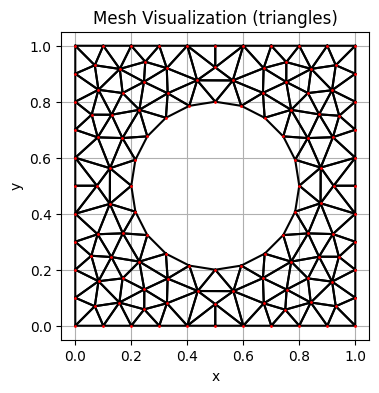

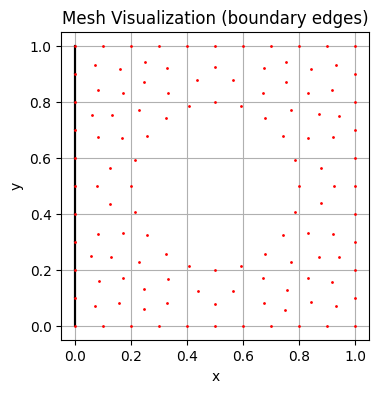

In [128]:
import meshio
import matplotlib.pyplot as plt

# Read mesh from file
mesh = meshio.read("rect_with_hole.msh")

# Extract node coordinates and triangle connectivity
points = mesh.points[:, :2]  # (x, y)
triangles = mesh.get_cells_type("triangle")
edges = mesh.get_cells_type("line") # edges on the left boundary

# Plot triangles
plt.figure(figsize=(8, 4))
for tri in triangles:
    coords = points[tri]
    coords = np.vstack((coords, coords[0]))  # close the triangle
    plt.plot(coords[:, 0], coords[:, 1], 'k-')
plt.plot(points[:, 0], points[:, 1], 'ro', markersize=1)
plt.gca().set_aspect('equal')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Mesh Visualization (triangles)")
plt.grid(True)
plt.show()

# Plot edges
plt.figure(figsize=(8, 4))
for edge in edges:
    coords = points[edge]
    coords = np.vstack((coords, coords[0]))  # close the line
    plt.plot(coords[:, 0], coords[:, 1], 'k-')
plt.plot(points[:, 0], points[:, 1], 'ro', markersize=1)
plt.gca().set_aspect('equal')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Mesh Visualization (boundary edges)")
plt.grid(True)
plt.show()


## 2. Define the shape functions
The second step in our Finite Element recipie consists on defining the shape functions and their derivatives. Here we will make use of the **isoparametric map** and **numerical integration** to re-use as much information as possible. 

Before defining the shape functions we first define the quadrature rule that will be used to integrate. Here we need to specify the location of the quadrature points and the corresponding weights. In this example we consider a $1$-point and $3$-point quadrature rules for the triangular elements. 

The function `GaussPoints` returns the coordinates $(\xi, \eta)$ of the quadrature point `gp` in the reference element, together with the corresponding weight $\alpha_{gp}$.

$$\int f(\xi,\eta) d\Omega_{ref} = \sum_{gp=1}^{GPE}f(\xi_{gp},\eta_{gp})\alpha_{gp}$$ 

In [129]:
def GaussPoints(points=1):
    if points == 1:
        # 1-point quadrature
        qp = np.array([[1/3, 1/3]])
        weights = np.array([0.5])
    elif points == 3:
        qp = np.array([[1/6, 1/6], [2/3, 1/6], [1/6, 2/3]])
        weights = np.array([1/6, 1/6, 1/6]) 
    else:
        raise NotImplementedError("Only order 1 and 2 implemented")
    return qp, weights


### Exercise:

Use the `GaussPoint` function to proof that the function $f(x,y)=xy$ can be integrated exactly with $3$-point quadrature and not $1$-point quadrature in a triangle of Vertices $\{[0,0],[0,1],[1,0]\}$.

$$ \int_T(xy)\ dT=\frac{1}{24} $$



In [130]:
# Your code goes here

Using linear polynomials, we will have the following shape functions for triangular elements:

$$N_1(\xi,\eta)=\xi,\qquad N_2(\xi,\eta)=\eta, \qquad N_3(\xi,\eta)=1-\xi-\eta,$$

The function `shape_functions` returns the shape functions and their gradients evaluated at given quadrature point $qp=(ξ,η)$. 

In [131]:
def shape_functions(qp):
    # Linear shape functions on triangle
    N = []
    dN_dxi = []
    for xi, eta in qp:
        N.append(np.array([1 - xi - eta, xi, eta]))
        dN_dxi.append(np.array([[-1, -1], [1, 0], [0, 1]]))
    return np.array(N), np.array(dN_dxi)

Let's see how these shape functions look like in the reference element.

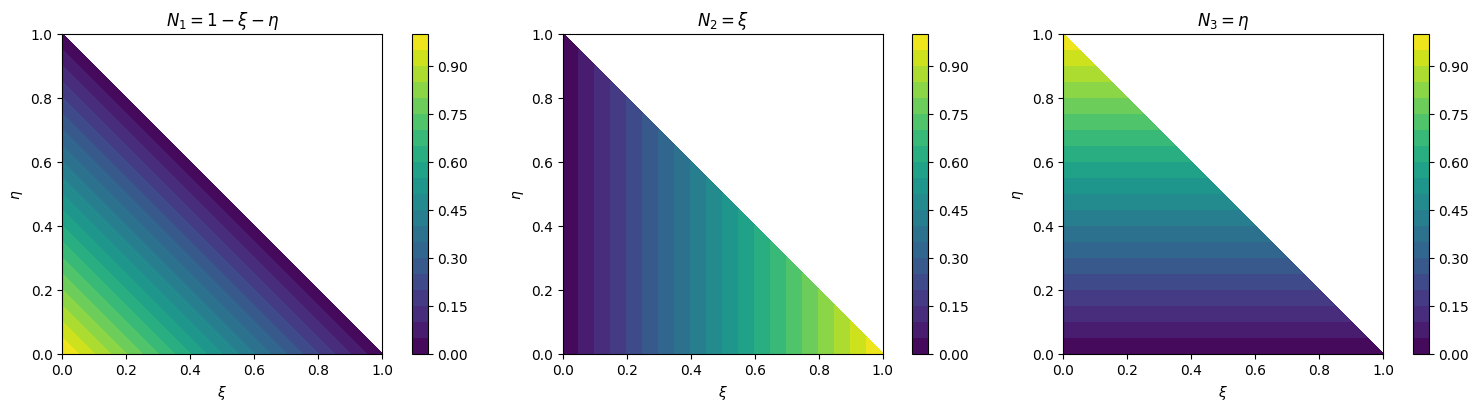

In [132]:
# Generate a grid of points inside the reference triangle
n = 50
xi = np.linspace(0, 1, n)
eta = np.linspace(0, 1, n)
xi_grid, eta_grid = np.meshgrid(xi, eta)
xi_flat = xi_grid.flatten()
eta_flat = eta_grid.flatten()

# Keep only points inside the reference triangle
mask = xi_flat + eta_flat <= 1.0
xi_valid = xi_flat[mask]
eta_valid = eta_flat[mask]
qp = np.vstack((xi_valid, eta_valid)).T

# Evaluate shape functions
N, dN_dxi = shape_functions(qp)

# Plot shape functions N1, N2, N3
fig, axs = plt.subplots(1, 3, figsize=(15, 4), constrained_layout=True)
titles = [r'$N_1 = 1 - \xi - \eta$', r'$N_2 = \xi$', r'$N_3 = \eta$']
for i in range(3):
    ax = axs[i]
    sc = ax.tricontourf(xi_valid, eta_valid, N[:, i], levels=20, cmap='viridis')
    ax.set_title(titles[i])
    ax.set_xlabel(r'$\xi$')
    ax.set_ylabel(r'$\eta$')
    ax.set_aspect('equal')
    fig.colorbar(sc, ax=ax)

plt.show()

## 3. Elemental matrices
Once we have the shape functions defined, we can proceed with the integration of the elemental matrices. The elemental stiffness matrix can be defined as:

$$K_{aibk}=\int_Ω C_{ijkl}\frac{∂N_a}{∂x_j}\frac{∂N_b}{∂x_l}\ dΩ$$

For practical reasons, since the strain and stress tensors are symmetrics in linear elasticity

$$ ε = \left[\begin{matrix}\varepsilon_{xx}&\varepsilon_{xy}\\
\varepsilon_{yx}&\varepsilon_{yy}\end{matrix}\right] $$

$$ \varepsilon_{xy} = \varepsilon_{yx}, $$

instead of working with the full tensor we work with a condensed vector:

$$ ε = \left[\begin{matrix}\varepsilon_{xx}\\\varepsilon_{yy}\\\varepsilon_{xy}\end{matrix}\right] $$

Then, if $\boldsymbol{u}=[u_1 v_1 u_2 v_2 u_3 v_3]^T$ is the vector of nodal displacements (with $u_i$ and $v_i$ being the displacements in the $x$- and $y$-directions for node $i$), then the strain at a point within the element can be written as:

$$\varepsilon=\boldsymbol{B}\boldsymbol{u}$$

$$\varepsilon=B_{ij} u_j $$

With the matrix $\boldsymbol{B}$ constructed as follows:

$$\boldsymbol{B}=\left[\begin{matrix}\frac{\partial N_1}{\partial x}&0&\frac{\partial N_2}{\partial x}&0&\frac{\partial N_3}{\partial x}&0\\
0&\frac{\partial N_1}{\partial y}&0&\frac{\partial N_2}{\partial y}&0&\frac{\partial N_3}{\partial y}\\
\frac{\partial N_1}{\partial y}&\frac{\partial N_1}{\partial x}&\frac{\partial N_2}{\partial y}&\frac{\partial N_2}{\partial x}&\frac{\partial N_3}{\partial y}&\frac{\partial N_3}{\partial x}\end{matrix}\right] $$

With this notation, the elasticity tensor can also be condensed to a 3 by 3 matrix $C_{ij}$. In the following function we define this tensor for the plane strain and plane stress cases:

In [133]:
def elasticity_tensor(E, nu, plane_stress=True):
    if plane_stress:
        C = E / (1 - nu**2) * np.array([
            [1, nu, 0],
            [nu, 1, 0],
            [0, 0, (1 - nu)/2]
        ])
    else:  # Plane strain
        C = E / ((1 + nu)*(1 - 2*nu)) * np.array([
            [1 - nu, nu, 0],
            [nu, 1 - nu, 0],
            [0, 0, (1 - 2*nu)/2]
        ])
    return C

The `element_stiffness` function computes the $6
× 6$ stiffness matrix for a linear triangular finite element in 2D elasticity. It loops over quadrature points, mapping shape function derivatives from the reference triangle to the physical element using the Jacobian. The strain-displacement matrix 
𝐵 is constructed at each point to relate nodal displacements to strains. The elemental stiffness contribution is then computed as $ K_e += B^T C B ∣\det J∣ w$, where $C$ is the constitutive matrix and $w$ is the quadrature weight. The function returns the elemental stiffness matrix $K_e$.

In [134]:
def element_stiffness(coords, C, qp, weights, dN_dxi):
    Ke = np.zeros((6, 6))
    for i, (xi_eta, w) in enumerate(zip(qp, weights)):
        J = coords.T @ dN_dxi[i]
        detJ = np.linalg.det(J)
        invJ = np.linalg.inv(J)
        dN_dx = dN_dxi[i] @ invJ

        B = np.zeros((3, 6))
        for a in range(3):
            B[0, 2*a] = dN_dx[a, 0]
            B[1, 2*a+1] = dN_dx[a, 1]
            B[2, 2*a] = dN_dx[a, 1]
            B[2, 2*a+1] = dN_dx[a, 0]

        Ke += B.T @ C @ B * detJ * w
    return Ke

Similarly, we compute the elemental mass matrix with this function:

In [135]:
def element_mass(coords, density, N, weights):
    Me = np.zeros((6, 6))
    for i, w in enumerate(weights):
        Ni = N[i]
        Ni_matrix = np.zeros((2, 6))
        Ni_matrix[0, 0::2] = Ni
        Ni_matrix[1, 1::2] = Ni

        J = coords.T @ dN_dxi[i]
        detJ = np.linalg.det(J)

        Me += density * (Ni_matrix.T @ Ni_matrix) * detJ * w
    return Me


And the force vector can be computed using the following function. Here, we assume we have a body force in the domain.

In [136]:
def element_force(coords, body_force, N, weights, dN_dxi):
    fe = np.zeros(6)
    for i, w in enumerate(weights):
        Ni = N[i]
        J = coords.T @ dN_dxi[i]
        detJ = np.linalg.det(J)
        for a in range(3):
            fe[2*a] += Ni[a] * body_force[0] * detJ * w
            fe[2*a+1] += Ni[a] * body_force[1] * detJ * w
    return fe


## 4. Assemble the global system

Once we have the elemental contributions we can assemble the global system. The function `assemble` assembles the contribution of the elemental matrices and vectors into the global matrices and vector according to local-to-global nodal map. 

Note that within this functions we call the elemental functions for each element in the mesh.

In [137]:
def assemble(mesh, elements, coords, C, density, body_force):
    # Calculate the total number of degrees of freedom (DOFs)
    num_dofs = coords.shape[0] * 2

    # Initialize global stiffness matrix, mass matrix, and force vector
    K = np.zeros((num_dofs, num_dofs))  # Stiffness matrix
    M = np.zeros((num_dofs, num_dofs))  # Mass matrix
    f = np.zeros(num_dofs)  # Force vector

    # Get quadrature points and weights for the triangle element
    qp, weights = GaussPoints()

    # Get shape functions and their derivatives in reference coordinates
    N, dN_dxi = shape_functions(qp)

    # Loop over all elements in the mesh
    for elem in elements:
        # Extract coordinates of the nodes for this element
        nodal_coords = coords[elem]
        
        # Define the degrees of freedom (DOFs) corresponding to the element's nodes
        dofs = np.array([[2*n, 2*n+1] for n in elem]).flatten()

        # Compute element stiffness matrix (Ke), mass matrix (Me), and force vector (fe)
        Ke = element_stiffness(nodal_coords, C, qp, weights, dN_dxi)
        Me = element_mass(nodal_coords, density, N, weights)
        fe = element_force(nodal_coords, body_force, N, weights, dN_dxi)

        # Assemble element contributions into global matrices and vector
        for i in range(6):
            for j in range(6):
                # Add the contributions to the global stiffness and mass matrices
                K[dofs[i], dofs[j]] += Ke[i, j]
                M[dofs[i], dofs[j]] += Me[i, j]
            
            # Add the force vector contributions to the global force vector
            f[dofs[i]] += fe[i]
    
    # Return the assembled global stiffness matrix, mass matrix, and force vector
    return K, M, f


## Main driver

We can use the functions defined above in the following main simulation driver:

In [157]:
# Problem parameters
E = 210e9  # Young's modulus in Pa
nu = 0.3  # Poisson's ratio
density = 7850  # Density in kg/m^3
body_force = np.array([0, -9.81 * density])  # Body force (gravity)
C = elasticity_tensor(E, nu)

# Assemble the global stiffness matrix, mass matrix, and force vector
K, M, f = assemble(mesh, triangles, points, C, density, body_force)

# Apply boundary conditions
# For simplicity, we will apply Dirichlet boundary conditions on the left side (l4). The value of u_dir is set to 0.
u_dir = 0.0

# Find the nodes on the left boundary (l4)
left_boundary_nodes = np.where(np.isin(points[:, 0], points[edges[:, 0], 0]))[0]
left_boundary_dofs = np.array([[2*n, 2*n+1] for n in left_boundary_nodes]).flatten()

# Set the corresponding rows and columns of K and M to zero
for dof in left_boundary_dofs:
    K[dof, :] = 0  # Set the row to zero
    K[:, dof] = 0  # Set the column to zero
    K[dof, dof] = 1  # Set the diagonal to 1
    M[dof, :] = 0  # Set the row to zero
    M[:, dof] = 0  # Set the column to zero
    M[dof, dof] = 1  # Set the diagonal to 1
    f[dof] = u_dir  # Set the force vector to 


Let's first solve the static solution:

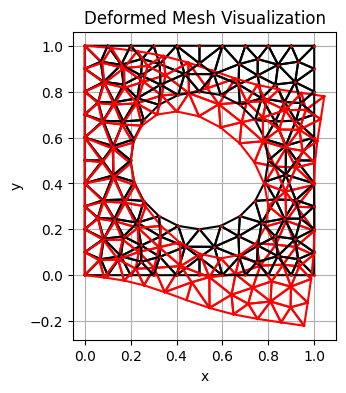

In [158]:
# Solve the system of equations
u = np.linalg.solve(K, f)

# Reshape the solution vector into a 2D array for visualization and magnify by 1e3
u_reshaped = u.reshape(-1, 2) * 1e5

# Plot the deformed mesh
plt.figure(figsize=(8, 4))
for tri in triangles:
    coords = points[tri]
    coords_displaced = coords + u_reshaped[tri]
    coords = np.vstack((coords, coords[0]))  # close the triangle
    coords_displaced = np.vstack((coords_displaced, coords_displaced[0]))  # close the triangle
    plt.plot(coords[:, 0], coords[:, 1], 'k-')
    plt.plot(coords_displaced[:,0],coords_displaced[:,1], 'r-')
plt.plot(points[:, 0], points[:, 1], 'ro', markersize=1)
plt.gca().set_aspect('equal')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Deformed Mesh Visualization")
plt.grid(True)
plt.show()

### Exercise:

Use the matrices obtained before to analyse a dynamic problem using an ODE solver

In [ ]:
# Your code goes here